# <center> Airlane Passengers Load Prediction - RAMP <center>
### <center> Tommy Tran, Thomas de MAREUIL - 04/12/19<center>


![title](cover.png)
<br>

## Table of contents
[1. Context and objective](#section1)

[2. Data Exploration (EDA) and Feature Engineering](#section2)

* [A. Structure of the initial datasets](##section2A)
* [B. Adding more external data](##section2B)
* [C. Data pre-processing: cleaning, merging, encoding](##section2C)


[3. Prediction](#section3)
* [A. Preparing the training dataset](##section3A)
* [B. Model selection](##section3B)
* [C. Hyperparameters tuning](##section3C)

[4. Conclusion](#section4)

<a id="section1"></a>
## 1. Context and objective

This report is our final project for the class [MAP536 - Python for Data Science](https://moodle.polytechnique.fr/course/view.php?id=6124).

The objective is to **forecast airplane passengers load** in the United States.

We were initially provided with:
* training data : information about US domestic flights between 2011 and 2013
* external data : meteorological information about US airports

Based on these first pieces of information, we identified several steps to guide our work and improve our predictions:

1. **Feature engineering**:  
    $\to$ look for additional external data  
    $\to$ clean it and merge it with preexisting data  
    $\to$ adjust data encoding  
    $\to$ check features relevance   
<br>
2. **Model selection and tuning:**  
    $\to$ select the best-performing model types  
    $\to$ try model averaging and stacking  
    $\to$ tune model hyperparameters with gridsearch  
<br>

In this report, we will go through these steps and present you the ideas we got, the techniques we tried, the models we explored and the results we obtained.

<a id="section2"></a>
## 2. Data Exploration and Feature Engineering

In [69]:
%matplotlib inline
import imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.set_option('display.max_columns', None)

<a id="##section2A"></a>
### A. Structure of the initial datasets

The initial **training dataset** contained information about 8901 US domestic flights: date (from 09/01/2011 to 03/05/2013), departure and arrival airports (20 different airports for both), how early tickets were booked (in weeks) and the number of passengers (our predicted variable).

In [70]:
problem = imp.load_source('', 'problem.py') #import a module with different methods
X_df, y_array = problem.get_train_data() #get_train_data() is one of these methods

X_train = X_df.copy()
y_train = y_array.copy()

In [71]:
X_train.shape

(8902, 5)

In [72]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [73]:
X_train.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
std_wtd             float64
dtype: object

In [74]:
print(min(X_train['DateOfDeparture']))
print(max(X_train['DateOfDeparture']))

2011-09-01
2013-03-05


In [75]:
X_train['Arrival'].unique()

array(['DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'MCO', 'LAS', 'CLT', 'MSP',
       'EWR', 'PHX', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'ATL', 'LGA',
       'SEA', 'IAH'], dtype=object)

$\rightarrow$ These commands gave us an overview of the data.

In [76]:
pd.DataFrame(data=X_train.isna().sum(), columns=["Number of NAs"]).transpose()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
Number of NAs,0,0,0,0,0


$\rightarrow$ There are no missing values.

In [77]:
X_train.skew()

WeeksToDeparture    0.270212
std_wtd             0.066525
dtype: float64

$\rightarrow$ Skewness is low.

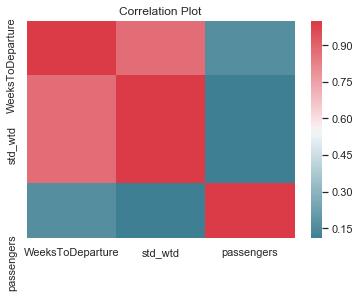

In [78]:
X_all=X_train.copy()
X_all["passengers"] = y_array

cor = X_all.corr(method='pearson')
sns.heatmap(cor, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Plot"); plt.show()

$\rightarrow$ `std_wtd` (standard deviation of weeks to departure) is strongly correlated to `WeeksToDeparture` and little correlated to `passengers`, therefore we chose not to use it.

The initial **external dataset** contained information about xx meteorological features for the 20 airports, during the corresponding time period.

Shape:  (11040, 24)


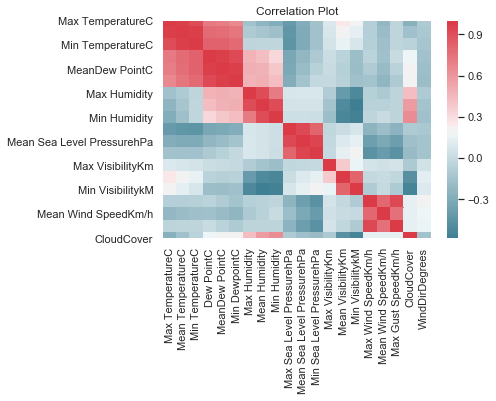

In [79]:
external_data_init = pd.read_csv('https://raw.githubusercontent.com/ramp-kits/air_passengers/master/submissions/starting_kit/external_data.csv')
print('Shape: ', external_data_init.shape)

cor_ext = external_data_init.corr(method = 'pearson')
sns.heatmap(cor_ext, cmap = sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Plot"); plt.show()

$\rightarrow$ We chose to select only the most relevant covariates with the feature extractor. Based on correlation, we kept only the Mean values for each feature that also had Min and Max values (i.e. `Temperature`, `Humidity`, etc.), and based on variable importance analysis we chose to drop **...**

<a id="##section2B"></a>
### B. Adding more external data

We tried to think about the determinants of airplane passenger load, and after online research we came out with:

_General / time-related data:_
* **Holidays**: we added a binary indicator to identify the holidays (ex: Matin Luther King Day, July 4th, Thanksgiving, etc.), with more plane traffic.
* **Jet Fuel Prices**: found in the IATA (International Air Transport Association) database, jet fuel prices tend to impact the price of tickets and therefore passenger load.
* **Plane load factor** (US BTS): percentage of empty seats in US domestic flights. We only found the average value per month, over the whole US market, which isn't very precise but gives and idea of plane load tendencies over the observed time period.  

_Data per airport:_
* **Airports ranking** (in terms of _total traffic_ ) and **frequentation** (in terms of commercial passengers per year)
* **City population and density** (IATA)  
* **Latitude and longitude (distances)**: the IATA database gave us latitude and longitude coordinates of the airports. We then explored the pyproj and geopy packages to compute distances, but we finally chose to use direct computation with the Haversine distance formula, which we embedded in the feature extractor.


_Data per flight route:_
* **Air time**: time spent in flight to link 2 airports (obtained from the US Bureau of Transportation Services (BTS) database).
* **Average ticket prices** (US BTS): average ticket prices between 2 given US airports, which has a direct impact on passenger load. We did not find day by day values, but we obtained an averafe price per quarter over the observed period, for each of the relevant flight routes.
* **Average daily number of passengers** for a given flight route (BTS): similarly, we found a quarter-by-quarter value of the daily number of passengers on the relevant flight routes, during the observed period.

#### B.1 Step by Step process for modifying the external data

In [93]:
#The original External Data, where each line represents the propoerty of an airport at a given data.
external = pd.read_csv('submissions/starting_kit_2/external_data.csv')
external.head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149


In [94]:
#To which we added the corresponding city thanks to the IATA data:
iata = pd.read_csv('data/IATA_US_CODES.csv')
iata['IATA Code']=iata['IATA Code'].astype(str)
iata['IATA Code']=iata['IATA Code'].str.rstrip()
iata_dep=iata.add_suffix('_Dep')
iata_arr=iata.add_suffix('_Arr')
iata['2018']=iata['2018'].str.replace(',','')
iata['2017']=iata['2017'].str.replace(',','')
iata['2016']=iata['2016'].str.replace(',','')
iata['2015']=iata['2015'].str.replace(',','')
iata['2018']=iata['2018'].str.replace('\xa0','')
iata['2017']=iata['2017'].str.replace('\xa0','')
iata['2016']=iata['2016'].str.replace('\xa0','')
iata['2015']=iata['2015'].str.replace('\xa0','')
iata['State']=iata['State'].str.replace('\xa0','')
iata['Major city served']=iata['Major city served'].str.replace('New York/','')
iata['Major city served']=iata['Major city served'].str.replace('/St. Paul','')
iata['Major city served']=iata['Major city served'].str.replace('Baltimore/','')
iata['Major city served']=iata['Major city served'].str.replace('/Tacoma','')
iata['Major city served']=iata['Major city served'].str.replace('/Fort Worth','')
iata['Major city served']=iata['Major city served'].str.replace(', D.C.','')
iata

,Rank_2018,Airports (large hubs),IATA Code,Major city served,State,2018,2017,2016,2015
0,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732
1,2,Los Angeles International Airport,LAX,Los Angeles,CA,42626783,41232432,39636042,36351226
2,3,O'Hare International Airport,ORD,Chicago,IL,39874879,38593028,37589899,36305668
3,4,Dallas/Fort Worth International Airport,DFW,Dallas,TX,32800721,31816933,31283579,31589832
4,5,Denver International Airport,DEN,Denver,CO,31363573,29809097,28267394,26280043
5,6,John F. Kennedy International Airport,JFK,New York,NY,30541459,29533154,29239151,27782369
6,7,San Francisco International Airport,SFO,San Francisco,CA,27794154,26900048,25707101,24190549
7,8,Seattle–Tacoma International Airport,SEA,Seattle,WA,24894338,22639124,21887110,21231781
8,9,McCarran International Airport,LAS,Las Vegas,NV,23655285,23364393,22833267,21824231
9,10,Orlando International Airport,MCO,Orlando,FL,23184634,21565448,20283541,18759938


In [95]:
external = external.merge(iata, left_on='AirPort',  right_on='IATA Code')
external['Major city served']=external['Major city served'].str.replace('\xa0','')
external.head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,Airports (large hubs),IATA Code,Major city served,State,2018,2017,2016,2015
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732


In [96]:
#We now add the us_cities.csv file to get more details on each city
us_cities = pd.read_csv('data/uscities.csv')
external=external.merge(us_cities, left_on=['Major city served', 'State'],right_on=['city', 'state_id'])
external.head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,Airports (large hubs),IATA Code,Major city served,State,2018,2017,2016,2015,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1,30334 30331 30332 30309 30308 30305 30307 3030...,1840016319
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1,30334 30331 30332 30309 30308 30305 30307 3030...,1840016319
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1,30334 30331 30332 30309 30308 30305 30307 3030...,1840016319
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1,30334 30331 30332 30309 30308 30305 30307 3030...,1840016319
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149,1,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1,30334 30331 30332 30309 30308 30305 30307 3030...,1840016319


In [97]:
#We drop duplicated columns or irrelevant data
external = external.drop(['city_ascii','state_id','state_name','county_fips','county_name',
                                'county_fips_all','county_name_all','source','military',
                                'incorporated','timezone','zips','id','Major city served',
                               'Airports (large hubs)'], axis=1).head()
external.head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,IATA Code,State,2018,2017,2016,2015,city,lat,lng,population,density,ranking
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1


In [98]:
#Data on fuel price
fuel = pd.read_csv('data/fuelprices.csv')
fuel=fuel.drop('Unnamed: 0',axis=1)
external=external.merge(fuel, left_on='Date', right_on='Date', how='left')
external = external.rename(
        columns={'U.S. Gulf Coast Kerosene-Type Jet Fuel Spot Price FOB (Dollars per Gallon)': 'Fuel_price'})
external['Fuel_price'].fillna(method='ffill', inplace=True)
external['Fuel_price']=external['Fuel_price'].str.replace(',','').astype(int)
external.head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,IATA Code,State,2018,2017,2016,2015,city,lat,lng,population,density,ranking,Fuel_price
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3088
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3038
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3038
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3038
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3038


In [99]:
#Load Factor
load_factor = pd.read_csv('data/load_factor_per_month.csv', sep=';')
external['Month'] = pd.DatetimeIndex(external['Date']).month
external['Year'] = pd.DatetimeIndex(external['Date']).year
external['Quarter'] = pd.DatetimeIndex(external['Date']).quarter
external = external.merge(load_factor, left_on=['Month', 'Year'], right_on=['Month', 'Year'])
external.head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,IATA Code,State,2018,2017,2016,2015,city,lat,lng,population,density,ranking,Fuel_price,Month,Year,Quarter,LOAD_FACTOR
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3088,9,2011,3,81.82
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3038,9,2011,3,81.82
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3038,9,2011,3,81.82
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3038,9,2011,3,81.82
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149,1,ATL,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3038,9,2011,3,81.82


In [ ]:
#rajouter ce que t'as fait pour le extra large ici

<a id="##section2C"></a>
### C. Data pre-processing: cleaning, merging, encoding

__*Cleaning the external dataset*__

A tricky part was merging this new data with the preexisting `external_data`, in order to have a single file to upload on RAMP.  

We first had to clean the data we found online to obtain a satisfying format, unsing mainly `pandas` and `numpy`. We had, for example, to drop and select values, to perform computations on columns, to match city names with airport codes, to change data types, to manipulate dates and times, to reindex rows, etc. As we found extensive data online, we were not confronted with the problem of missing values.  

Then we had to merge our new data with the meteorological dataset, which was sorted out by airport and by date. Therefore, joining the new data per airport and the new time-related data wasn't complicated.


__*Merging with the training dataset*__

We then built the feature extractor to select the features from the new external dataset, merge them with the training data and encode them.  

As the training data is sorted out by flight route, not by airport, the feature extractor joins the external data twice (based on the 2 aiports in the itinerary). The feature extractor adds `_dep` and `_arr` suffixes in the column names, in order to distinguish information about departure and arrival airports.

In [104]:

import pandas as pd
import os
from math import *


class FeatureExtractor(object):
    def __init__(self):
        pass


    def fit(self, X_df, y_array):
        pass


    def transform(self, X_df):
        def haversine(lon1, lat1, lon2, lat2):
            """
            Calculate the great circle distance between two points 
            on the earth (specified in decimal degrees)
            """
            # convert decimal degrees to radians 
            lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

            # haversine formula 
            dlon = lon2 - lon1 
            dlat = lat2 - lat1 
            a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
            c = 2 * asin(sqrt(a)) 
            r = 6371 # Radius of earth in kilometers. Use 3956 for miles
            return c * r
        
        
        X_encoded = X_df.copy()
        __file__='submissions/starting_kit/'
        path = os.path.dirname(__file__)
        external_data_large = pd.read_csv(os.path.join(path, 'external_data.csv'))
        
        # 2) Starting with weather data transformation and merging with X_encoded:

        X_weather = external_data_large[['Date', 'AirPort', 'Mean TemperatureC', 'MeanDew PointC', 
                                         'Mean Humidity', 'Mean Sea Level PressurehPa', 'Mean VisibilityKm',
                                         'Mean Wind SpeedKm/h', 'CloudCover']]
        X_weather = X_weather.rename(columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})

        X_encoded = pd.merge(X_encoded, X_weather, how = 'left',
            left_on = ['DateOfDeparture', 'Arrival'],
            right_on = ['DateOfDeparture', 'Arrival'],
            sort = False)
        
        # 3) Airport external data transformation and merging:

        airport_data = external_data_large[['Date', 'AirPort','Rank_2018','State','city','lat',
                                            'lng','population','density','Fuel_price','Holiday',
                                            'LOAD_FACTOR','2018_freq','2017_freq', '2016_freq',
                                            '2015_freq']]
    
        ## We need to distinguish data related to departure and arrival airports
        Dep_data = airport_data.add_suffix('_Dep')
        Arr_data = airport_data.add_suffix('_Arr')
        
        ## We then merge departure and arrival information with X_encoded
        X_encoded = pd.merge(X_encoded, Dep_data, how = 'left', 
            left_on = ['DateOfDeparture', 'Departure'],
            right_on = ['Date_Dep', 'AirPort_Dep'],
            sort = False)
        
        X_encoded = pd.merge(X_encoded, Arr_data, how = 'left', 
            left_on = ['DateOfDeparture', 'Arrival'],
            right_on = ['Date_Arr', 'AirPort_Arr'],
            sort = False)
        
        ## Distance calculation
        X_encoded['Distance'] = X_encoded.apply(lambda x: 
            haversine(x['lng_Dep'], x['lat_Dep'], x['lng_Arr'], x['lat_Arr']), axis = 1)

        # 4) Route external data transformation and merging
        
        ## Add route information in X_encoded
        X_encoded['ROUTE'] = X_encoded[['Departure', 'Arrival']].apply(''.join, axis=1)
        
        ## Dummy Dates
        X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 
            5 == 1).astype(float)
        X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
        X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
        X_encoded['quarter'] = X_encoded['DateOfDeparture'].dt.quarter
        X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
        X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
        X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
        X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
        X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date:
            (date - pd.to_datetime("1970-01-01")).days)
        
        ## Select flight route data in external dataset
        route_data = external_data_large[['Year_route', 'Quarter_route', 'miles_distance', 
                                          'daily_passengers', 'average_fare', 'ROUTE', 'AIR_TIME_MEAN']]
        
        ## Merge the flight route data with X_encoded
        X_encoded = pd.merge(X_encoded, route_data, how = 'left', 
            left_on = ['year','quarter','ROUTE'],
            right_on = ['Year_route','Quarter_route','ROUTE'],
            sort = False)
    
        # 5) Dummy variables and encoding:

        ## Dummy Departure / Arrival airports
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix = 'd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix = 'a'))
           
        ## One-hot encoding of categorical features
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)

        X_encoded['Rank_2018_Arr'] = X_encoded['Rank_2018_Arr'].astype(int)
        X_encoded['Rank_2018_Dep'] = X_encoded['Rank_2018_Dep'].astype(int)
        
        # 5) Final feature selection (dropping unuseful features):
        
        X_encoded = X_encoded.drop(['Date_Dep','Date_Arr','city_Dep','city_Arr','AirPort_Dep',
                                  'State_Dep', 'AirPort_Arr', 'State_Arr','Fuel_price_Arr',
                                  'Holiday_Arr','year','month','week','day','weekday','lat_Dep',
                                  'lng_Dep','lat_Arr','lng_Arr','ROUTE','std_wtd'], axis=1)
        return X_encoded

__*Encoding categorical features*__

For categorical features, we tried several encoding methods, especially target encoding and one-hot encoding.   
We first split dates into year, month and weekday to encode this information.   
We then tried target encoding, which did not yield efficient results. We tried to group data by month and consider it as time series, which wasn't a good direction either. 

$\rightarrow$ We therefore sticked to **one-hot encoding** for `months` and `weekdays`.

<a id="section3"></a>
## 3. Prediction

<a id="##section3B"></a>
### B. Model Selection

We tried and evaluated several regression models locally, in order to obtain the lowest error rate on our testing set. Here are the results of our different tries, ranked from lowest to highest test rmse:

* **Exterme Gradient Boosting (`XGBoost`)**: the best-performing model, which we finally selected.  

```
----------------------------
train rmse = 0.137 ± 0.0025
test rmse = 0.267 ± 0.0072
```


In [105]:
#Pre-processing
fe = FeatureExtractor()
X_train = X_df.copy()
y_train = y_array.copy()
X_train =fe.transform(X_train)
X_train

,WeeksToDeparture,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,CloudCover,Rank_2018_Dep,population_Dep,density_Dep,Fuel_price_Dep,Holiday_Dep,LOAD_FACTOR_Dep,2018_freq_Dep,2017_freq_Dep,2016_freq_Dep,2015_freq_Dep,Rank_2018_Arr,population_Arr,density_Arr,LOAD_FACTOR_Arr,2018_freq_Arr,2017_freq_Arr,2016_freq_Arr,2015_freq_Arr,Distance,Weekend,quarter,n_days,Year_route,Quarter_route,miles_distance,daily_passengers,average_fare,AIR_TIME_MEAN,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,29,21,63,1010,16,29,5,3,8675982.0,4612.0,2.719,0,86.62,39874879,38593028,37589899,36305668,4,5733259.0,1524.0,86.62,32800721,31816933,31283579,31589832,1285.250403,0.0,2,15510,2012.0,2.0,802.0,3220.0,228.67,7560.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,25,-6,14,1008,16,15,3,9,2073045.0,1747.0,3.247,0,80.64,23655285,23364393,22833267,21824231,5,2787266.0,1774.0,80.64,31363573,29809097,28267394,26280043,990.537032,0.0,3,15593,2012.0,3.0,628.0,2286.0,123.86,4407.42,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,19,16,77,1016,13,8,5,5,2787266.0,1774.0,3.158,0,84.23,31363573,29809097,28267394,26280043,2,12815475.0,3295.0,84.23,42626783,41232432,39636042,36351226,1354.641049,0.0,4,15618,2012.0,4.0,862.0,4379.0,172.05,5667.64,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,19,10,58,1026,16,6,1,1,5228750.0,1384.0,2.881,0,83.63,51866464,50251964,50501858,49340732,3,8675982.0,4612.0,83.63,39874879,38593028,37589899,36305668,942.326564,1.0,4,15256,2011.0,4.0,606.0,2746.0,193.12,3693.83,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,12,8,79,1025,12,8,7,5,2787266.0,1774.0,3.237,0,78.90,31363573,29809097,28267394,26280043,7,3603761.0,7286.0,78.90,27794154,26900048,25707101,24190549,1536.901253,0.0,1,15391,2012.0,1.0,967.0,2681.0,182.97,5300.04,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

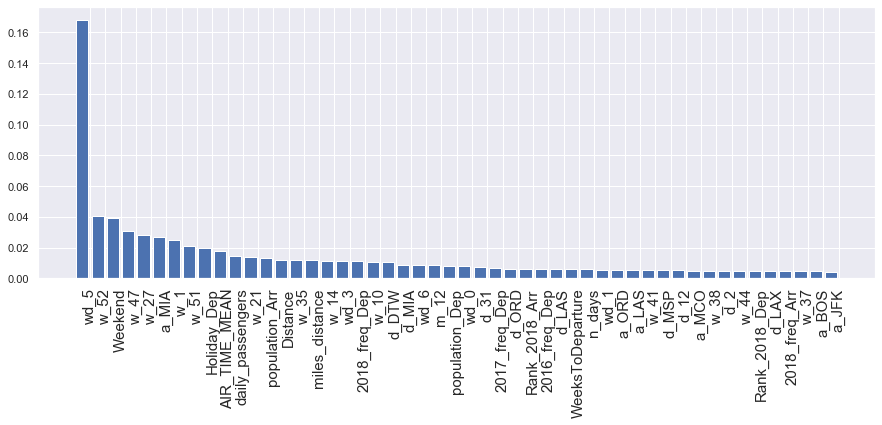

In [107]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05, max_depth= 7, min_child_weight=4, n_estimators= 500, nthread= 4, objective='reg:linear', silent=1, subsample= 0.7)
xgb_model.fit(X_train, y_train)
X_columns=X_train.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(xgb_model.feature_importances_)[::-1][:50]

importances = xgb_model.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);
#plots showing how important each column is in the prediction


* **Gradient Boosting**

```
----------------------------
train rmse = 0.405 ± 0.0117
test rmse = 0.302 ± 0.005
```

* **Random Forest**

```
----------------------------
train rmse = 0.529 ± 0.033
test rmse = 0.881 ± 0.023
```

* **Lasso Regression**

```
----------------------------
train rmse = 0.591 ± 0.0322
test rmse = 0.629 ± 0.023
```

* **Elastic Net Regression**

```
----------------------------
train rmse = 0.590 ± 0.032
test rmse = 0.629 ± 0.032
```

* **AdaBoost**

```
----------------------------
train rmse = 0.700 ± 0.0133
test rmse = 0.726 ± 0.032
```

* **Linear Regression**: **try this one**

```
----------------------------
train rmse = 0.898 ± 0.013
test rmse = 0.841 ± 0.023
```


We also tried **averaging** the 3 best-performing models (XGBoost, GradientBoosting and RandomForest), which did not yield better results - probably due to the fact that these models are already ensembling methods.

In [50]:
#Final Regressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg =xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05, max_depth= 10, min_child_weight=4, n_estimators= 5000, nthread= 4, objective='reg:linear', silent=1, subsample= 0.7)

        #self.enc=TargetEncoder(cols=['DateOfDeparture','Departure', 'Arrival', 'State_Dep','city_Dep','State_Arr','city_Arr'])




    def fit(self, X, y):
        #X = self.enc.fit_transform(X, y)
        self.reg.fit(X, y)
        

    def predict(self, X):
        return self.reg.predict(X)


**[Try model stacking]**

In the XGBoost case, the model seems to overfit a little bit, but it is not significant.

<a id="##section3C"></a>
### C. Hyperparameters tuning

We performed Grid Search using the `GridSearchCV` command (the `RandomizedSearchCV`is too costly), which is still quite demanding computationaly speaking but allowed us to come up with an efficient set of parameters for our XGBoost and gain **[...]** pp compared to default parameters.

In [47]:
#Hyperparamaeters tuning performed for the model above
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 10, 15, 20, 30],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

<a id="section4"></a>
## 4. Conclusion

**[What we answer to the project questions]**

Questions  
1. How to allocate planes among possible routes?
2. How many passengers will travel at a given date?

Bonus (advanced)  
* model interpretability  
* evaluate uncertainty in predictions

**[What we learned personnaly (models, preprocessing, hyperparem, github, etc.]**